Write your findings & recommendations as if you are presenting to someone outside of the
data science team (i.e. an engineer or product manager) who will be making decisions
about the initial experience users receive when they first create their accounts. Their work
will focus on improving this experience to increase adoption, so they'd like to know how
successful Asana currently is at getting different types of users to adopt.

### Data Ingestion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:
users = pd.read_csv("takehome_users-intern.csv")
user_engagement = pd.read_csv("takehome_user_engagement-intern.csv")

# users = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_users-intern.csv")
# user_engagement = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_user_engagement-intern.csv")

### Data Cleaning

In [3]:
users = users.rename(columns={'object_id': 'user_id'}) #rename object_id to user_id for future join
users['email'] = users['email'].str.lower() #converting all email to lowercase

users['creation_time'] = pd.to_datetime(users['creation_time'], unit = 'ns')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

#changing type to category
users['creation_source'] = users['creation_source'].astype('category') 
users['org_id'] = users['org_id'].astype('category')

#changing type to boolean
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype(bool)
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype(bool)

#filling NaNs as 0, since the minimum value in the invited_by_user_id column is 3.0
users['invited_by_user_id'].fillna(0, inplace=True)
users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

I removed the `visited` column in `user_engagement` since it only consists of 1s. 

In [4]:
user_engagement = user_engagement.drop(["visited"], axis = 1)

We're going to use `user_engagement` to calculate the adoption rate. 
We create a new dataframe to store `user_id` as the key and the list of `timestamps` as the value. 

In [5]:
list_of_users = user_engagement.user_id.unique().tolist() #convert user_id column to list
hMap = {i: [] for i in list_of_users} 
for index,row in user_engagement.iterrows(): 
    hMap[row['user_id']].append(row['time_stamp'])

user_engagement_revised = pd.DataFrame(list(hMap.items()), columns=['user_id', 'login_dates']) #convert hashmap to dataframe

# Convert each string in the list to a datetime object using apply and a lambda function
user_engagement_revised['login_dates'] = user_engagement_revised['login_dates'].apply(lambda x: [pd.to_datetime(date_str) for date_str in x])

user_engagement_revised.head()

,user_id,login_dates
0,1,[2014-04-22 03:53:30]
1,2,"[2013-11-15 03:45:04, 2013-11-29 03:45:04, 201..."
2,3,[2013-03-19 23:14:52]
3,4,[2013-05-22 08:09:28]
4,5,[2013-01-22 10:14:20]


### 1) Calculating Adoption Rate

We define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period. Because we believe that adopted users are more likely to be successful at using Asana in the long term than those that are not adopted, we want to know what things are likely indicators of future adoption. 

To check whether a user is adopted, we need to check if a subset of three consecutive dates are within a 7-day period. 

In [11]:
from datetime import timedelta

def has_adopted(row):
    sorted_dates = sorted(row['login_dates'])
    
    # Initialize variables to track consecutive logins and the start date of the current window
    current_start_date = None
    consecutive_logins = 0
    
    k = 3 #size of sliding window 
    seven_days = timedelta(days=7) # Define the 7-day time window
    list_of_dates = []

    for i in range(len(sorted_dates) - k + 1):
        if current_start_date is None:
            current_start_date = sorted_dates[i]
            consecutive_logins = 1
            list_of_dates.append(current_start_date)
        elif sorted_dates[i] - current_start_date <= seven_days:
            consecutive_logins += 1
            list_of_dates.append(sorted_dates[i])
        else:
            current_start_date = sorted_dates[i]
            list_of_dates = [current_start_date]
            consecutive_logins = 1
        
        if consecutive_logins >= 3:
            #print(list_of_dates)
            return True

    return False

In [12]:
user_engagement_revised['has_adopted'] = user_engagement_revised.apply(has_adopted, axis=1) #apply the has_adopted function to each row

In order to calculate the adoption rate, we need to compare the number of users that are adopted vs the total number of users. To do so, we need to join `users` and `user_engagement_revised`.

In [13]:
merged_df = users.merge(user_engagement_revised, on = 'user_id', how = 'outer')

#replace all NaNs in the has_adopted column with False
merged_df['has_adopted'].fillna(False, inplace=True)

In [22]:
#Adoption rate formula = (has_adopted == False)/ total_users
total_adoption_rate = (merged_df['has_adopted'].sum()) / len(merged_df) 
print("{:.2f}".format(total_adoption_rate))

0.13


The total adoption rate is 0.13. 

We can also calculate the adoption rates of users by `creation_source`.

/var/folders/y3/1ld116210xs2ztcb6hbqjrhm0000gn/T/ipykernel_78730/2701690573.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adoption_rate = merged_df.groupby('creation_source')['has_adopted'].mean()


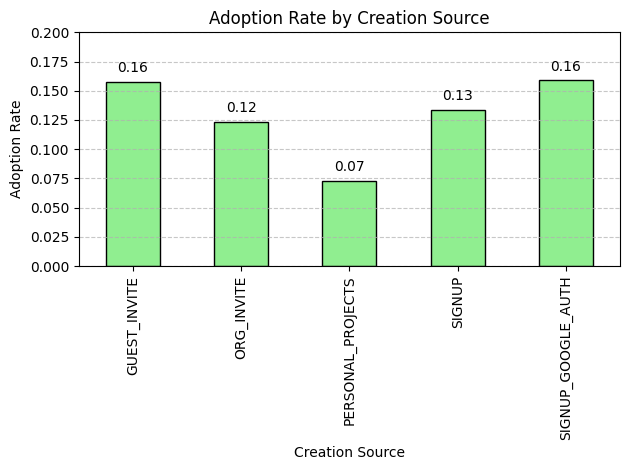

In [48]:
# Calculate the adoption rate by 'creation_source'
adoption_rate = merged_df.groupby('creation_source')['has_adopted'].mean()

# Plot the adoption rate
ax = adoption_rate.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Adoption Rate by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the adoption rate by 'creation_source'
adoption_rate = merged_df.groupby('creation_source')['has_adopted'].mean()

# Plot the adoption rate
ax = adoption_rate.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Adoption Rate by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

We can also compare the adoption rates by `opted_in_to_mailing_list` and `enabled_for_marketing_drip`.

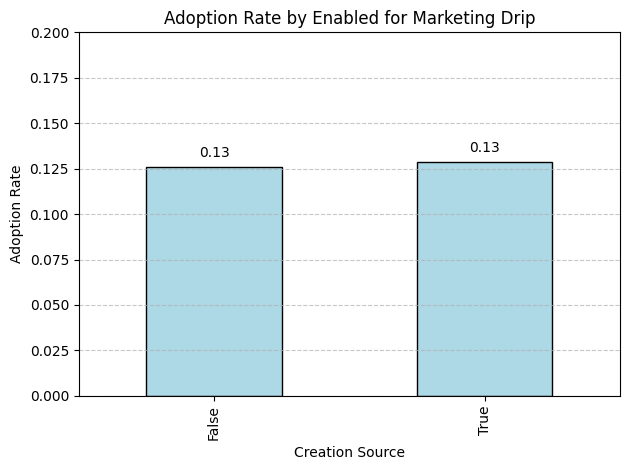

In [57]:
# Calculate the adoption rate by 'creation_source'
enabled_for_marketing_drip_adoption_rate = merged_df.groupby('enabled_for_marketing_drip')['has_adopted'].mean()

# Plot the adoption rate
ax1 = enabled_for_marketing_drip_adoption_rate.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Adoption Rate by Enabled for Marketing Drip')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax1.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

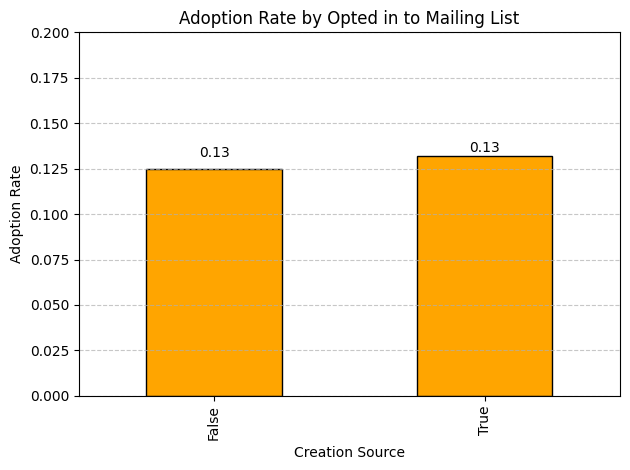

In [56]:
# Calculate the adoption rate by 'creation_source'
opted_in_to_mailing_list_adoption_rate = merged_df.groupby('opted_in_to_mailing_list')['has_adopted'].mean()

# Plot the adoption rate
ax2 = opted_in_to_mailing_list_adoption_rate.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Adoption Rate by Opted in to Mailing List')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax2.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

3. Segment, Segment, Segment
Segmentation is key to unlocking insights in analytics. The goal of segmentation is to split your data along some dimension so that you can assess performance between different groups. In a product analytics setting, some common segmentations include free vs paid users, device type (desktop web vs mobile web vs native app), traffic source (people coming from search engines, paid marketing, people directly typing in your company’s URL into their browser, etc.), and day of the week.

I tend to try many possible segmentations to see what provides interesting results. If you’re not sure where to start, categorical columns are good candidates for segmentation. Sometimes, you’ll want to filter out low-volume categories or group them into an ‘Other’ category to remove clutter from your visualization.

You can also create boolean columns from numerical ones (e.g. whether a user spent more than $50, if user had activity on the weekend) or discretize columns by creating different buckets (e.g. timestamp to morning/afternoon/ night, order values into buckets of $10–20, $20–30, $30+).